## 資料前處理

In [1]:
import numpy
import pandas as pd
from sklearn import preprocessing
numpy.random.seed(10)

In [2]:
df = pd.read_excel("titanic3.xls")

In [3]:
cols=['survived','name','pclass' ,'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
df = df[cols]

In [4]:
msk = numpy.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [6]:
print('total:',len(df),
      'train:',len(train_df),
      'test:',len(test_df))

total: 1309 train: 1034 test: 275


In [7]:
def PreprocessData(raw_df):
    df=raw_df.drop(['name'], axis=1)
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex']= df['sex'].map({'female':0, 'male': 1}).astype(int)
    x_OneHot_df = pd.get_dummies(data=df,columns=["embarked" ])

    ndarray = x_OneHot_df.values
    Features = ndarray[:,1:]
    Label = ndarray[:,0]

    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaledFeatures=minmax_scale.fit_transform(Features)    
    
    return scaledFeatures,Label

In [8]:
train_Features,train_Label = PreprocessData(train_df)
test_Features,test_Label = PreprocessData(test_df)

## 建立模型

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [10]:
# 建立推疊模型
model = Sequential()

In [11]:
# 建立輸出層與隱藏層1
model.add(Dense(units=40, # 隱藏層1共有40個神經元，
                input_dim=9, # input_dim代表有9個輸入特徵
                kernel_initializer='uniform', # 使用常態分佈初始化weight和bias
                activation='relu'))

In [12]:
# 建立隱藏層2
model.add(Dense(units=30,
                kernel_initializer='uniform',
                activation='relu'))

In [13]:
# 建立輸出層
model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))

In [14]:
# 設定模型參數，loss_function，optimizer，評估方式為accuracy
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [16]:
#開始訓練
train_history = model.fit(x=train_Features,
                          y=train_Label,
                          validation_split=0.1, # keras會自動將90%作為訓練，10%測試，因此1034*0.9=930為實際訓練資料
                          epochs=30, # 執行30次訓練週期
                          batch_size=30,verbose=2) # 每一批次30筆資料，所以每一次執行約為930/30=31筆資料，verbose顯示訓練過程

Train on 930 samples, validate on 104 samples
Epoch 1/30
 - 0s - loss: 0.6899 - acc: 0.5774 - val_loss: 0.6706 - val_acc: 0.7885
Epoch 2/30
 - 0s - loss: 0.6678 - acc: 0.5968 - val_loss: 0.5916 - val_acc: 0.7885
Epoch 3/30
 - 0s - loss: 0.6102 - acc: 0.6667 - val_loss: 0.4947 - val_acc: 0.8173
Epoch 4/30
 - 0s - loss: 0.5463 - acc: 0.7645 - val_loss: 0.4628 - val_acc: 0.7596
Epoch 5/30
 - 0s - loss: 0.5067 - acc: 0.7602 - val_loss: 0.4539 - val_acc: 0.7885
Epoch 6/30
 - 0s - loss: 0.4909 - acc: 0.7645 - val_loss: 0.4400 - val_acc: 0.7788
Epoch 7/30
 - 0s - loss: 0.4821 - acc: 0.7591 - val_loss: 0.4424 - val_acc: 0.7885
Epoch 8/30
 - 0s - loss: 0.4788 - acc: 0.7581 - val_loss: 0.4353 - val_acc: 0.7981
Epoch 9/30
 - 0s - loss: 0.4730 - acc: 0.7624 - val_loss: 0.4277 - val_acc: 0.7885
Epoch 10/30
 - 0s - loss: 0.4698 - acc: 0.7785 - val_loss: 0.4257 - val_acc: 0.7981
Epoch 11/30
 - 0s - loss: 0.4658 - acc: 0.7634 - val_loss: 0.4228 - val_acc: 0.8173
Epoch 12/30
 - 0s - loss: 0.4641 - acc:

In [17]:
#以圖表顯示訓練過程
import matplotlib.pylab as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'], loc='upper left') #設定圖例
    plt.show()

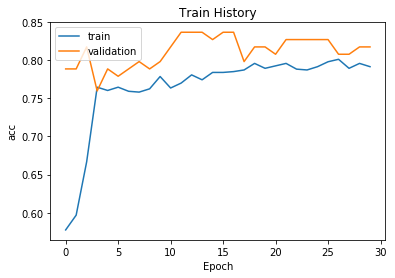

In [18]:
show_train_history(train_history, 'acc', 'val_acc')

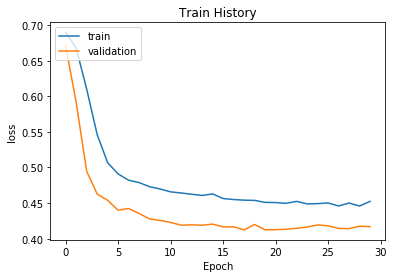

In [19]:
show_train_history(train_history, 'loss', 'val_loss')

In [20]:
#評估模型準確率
scores = model.evaluate(test_Features, test_Label)
print("accuracy=",scores[1])

275/275 [==============================] - 0s 39us/step
accuracy= 0.8109090913425793


## 加入Jack & Rose的資料

根據電影推斷
- Jack是3等艙，Rose是頭等艙
- Jack是男性，Rose是女性
- Jack票價是5，Rose是100
- Jack年齡是23，Rose是20

In [23]:
df.head(2)

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S


In [22]:
Jack = pd.Series([0 ,'Jack',3, 'male'  , 23, 1, 0,  5.0000, 'S'])
Rose = pd.Series([1 ,'Rose',1, 'female', 20, 1, 0, 100.0000, 'S'])

In [24]:
JR_df = pd.DataFrame([list(Jack),list(Rose)],  
                  columns=['survived', 'name','pclass', 'sex', 
                   'age', 'sibsp','parch', 'fare','embarked'])

In [25]:
df = pd.concat([df,JR_df])

In [26]:
df.tail(2)

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


### 進行預測

In [27]:
all_Features, Label = PreprocessData(df)

In [28]:
all_probability = model.predict(all_Features)

In [29]:
# 前10筆乘客預測的生存機率
all_probability[:10]

array([[0.9769952 ],
       [0.61762613],
       [0.9723875 ],
       [0.4099357 ],
       [0.97141   ],
       [0.27053553],
       [0.9492562 ],
       [0.3274515 ],
       [0.9472533 ],
       [0.28492376]], dtype=float32)

In [30]:
pd = df
pd.insert(len(df.columns), 'probability',all_probability)

In [34]:
# Jack & Rose生存機率
pd.tail(2)

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.148969
1,1,Rose,1,female,20.0,1,0,100.0,S,0.969478


## 找出鐵達尼號數據背後感人故事

In [35]:
# 生存機率高卻沒有存活的人，書中有解釋
pd[(pd['survived']==0) &  (pd['probability']>0.9) ]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.972387
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.971410
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.977875
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.975924
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.963597


In [36]:
pd.head(5)

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S,0.976995
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S,0.617626
2,0,"Allison, Miss. Helen Loraine",1,female,2.0000,1,2,151.5500,S,0.972387
3,0,"Allison, Mr. Hudson Joshua Creighton",1,male,30.0000,1,2,151.5500,S,0.409936
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0000,1,2,151.5500,S,0.971410
